# Projeto 1
## Introdução a Data Science
### Alunos
Gabriel de Melo Evangelista (gme@cin.ufpe.br)

Maria Luísa Leandro de Lima (mlll@cin.ufpe.br)
### Tema: Powerlifting
https://openpowerlifting.gitlab.io/opl-csv/bulk-csv-docs.html

- Força homem vs mulher

- categorias: raw/singleply se eh igual ou se tem diferença

- ver a diferença de uma pessoa com os anos

- discretizar os pesos usados em exercicios pra dps categorizar usar pra alguma coisa

- se tiver nan, ja da usar a parte acima com o knn fancy la

- o peso que as pessoas conseguem executar o exercicio é menor que o peso que eles falham

- ver se tem impacto ser tested ou n

- ajeitar a idade bugada pra zero
  
- Criar um plot com o peso levantado com melhores dos equipamentos, separando por idade
  
- Criar um plot com as 4 tentativas de levantamento para ver a melhoria das pessoas

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Leitura do dataset e primeiro estudo

In [2]:
df = pd.read_csv('openpowerlifting-2022-07-18-25fdebe0.csv')

C:\Users\lu-lu\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (33,35,38) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df.shape

(2742446, 41)

In [36]:
df.columns

Index(['Name', 'Sex', 'Event', 'Equipment', 'Age', 'AgeClass',
       'BirthYearClass', 'Division', 'BodyweightKg', 'WeightClassKg',
       'Squat1Kg', 'Squat2Kg', 'Squat3Kg', 'Squat4Kg', 'Best3SquatKg',
       'Bench1Kg', 'Bench2Kg', 'Bench3Kg', 'Bench4Kg', 'Best3BenchKg',
       'Deadlift1Kg', 'Deadlift2Kg', 'Deadlift3Kg', 'Deadlift4Kg',
       'Best3DeadliftKg', 'TotalKg', 'Place', 'Dots', 'Wilks', 'Glossbrenner',
       'Goodlift', 'Tested', 'Country', 'State', 'Federation',
       'ParentFederation', 'Date', 'MeetCountry', 'MeetState', 'MeetTown',
       'MeetName'],
      dtype='object')

In [4]:
df.head()

,Name,Sex,Event,Equipment,Age,AgeClass,BirthYearClass,Division,BodyweightKg,WeightClassKg,...,Tested,Country,State,Federation,ParentFederation,Date,MeetCountry,MeetState,MeetTown,MeetName
0,Alona Vladi,F,SBD,Raw,33.0,24-34,24-39,O,58.30,60,...,Yes,Russia,NaN,GFP,NaN,2019-05-11,Russia,NaN,Bryansk,Open Tournament
1,Galina Solovyanova,F,SBD,Raw,43.0,40-44,40-49,M1,73.10,75,...,Yes,Russia,NaN,GFP,NaN,2019-05-11,Russia,NaN,Bryansk,Open Tournament
2,Daniil Voronin,M,SBD,Raw,15.5,16-17,14-18,T,67.40,75,...,Yes,Russia,NaN,GFP,NaN,2019-05-11,Russia,NaN,Bryansk,Open Tournament
3,Aleksey Krasov,M,SBD,Raw,35.0,35-39,24-39,O,66.65,75,...,Yes,Russia,NaN,GFP,NaN,2019-05-11,Russia,NaN,Bryansk,Open Tournament
4,Margarita Pleschenkova,M,SBD,Raw,26.5,24-34,24-39,O,72.45,75,...,Yes,Russia,NaN,GFP,NaN,2019-05-11,Russia,NaN,Bryansk,Open Tournament


In [27]:
df['Event'].value_counts()
## Vamos usar apenas os registros do evento SBD, que tem as medições dos 3 exercicios: squat, bench e deadlift

SBD    1884213
B       627261
D       157483
BD       53937
S        14886
SB        2876
SD        1790
Name: Event, dtype: int64

In [59]:
samples = df[df['Event']=='SBD'].copy()
samples.drop('Event', axis=1, inplace = True)

In [60]:
samples['Equipment'].value_counts()
## Vamos usar apenas os registros que usam nenhum equipamento (raw) ou o equipamento single-ply 

Single-ply    1063429
Raw            593985
Wraps          174066
Multi-ply       52237
Unlimited         495
Straps              1
Name: Equipment, dtype: int64

In [61]:
samples = samples[(samples['Equipment'] == 'Single-ply') | (samples['Equipment'] == 'Raw')]

In [65]:
samples.shape

(1657414, 40)

In [52]:
print(samples.dtypes)

Name                 object
Sex                  object
Event                object
Equipment            object
Age                 float64
AgeClass             object
BirthYearClass       object
Division             object
BodyweightKg        float64
WeightClassKg        object
Squat1Kg            float64
Squat2Kg            float64
Squat3Kg            float64
Squat4Kg            float64
Best3SquatKg        float64
Bench1Kg            float64
Bench2Kg            float64
Bench3Kg            float64
Bench4Kg            float64
Best3BenchKg        float64
Deadlift1Kg         float64
Deadlift2Kg         float64
Deadlift3Kg         float64
Deadlift4Kg         float64
Best3DeadliftKg     float64
TotalKg             float64
Place                object
Dots                float64
Wilks               float64
Glossbrenner        float64
Goodlift            float64
Tested               object
Country              object
State                object
Federation           object
ParentFederation    

In [53]:
samples.describe()

,Age,BodyweightKg,Squat1Kg,Squat2Kg,Squat3Kg,Squat4Kg,Best3SquatKg,Bench1Kg,Bench2Kg,Bench3Kg,...,Deadlift1Kg,Deadlift2Kg,Deadlift3Kg,Deadlift4Kg,Best3DeadliftKg,TotalKg,Dots,Wilks,Glossbrenner,Goodlift
count,849044.000000,1.634733e+06,565055.000000,559320.000000,544828.000000,3619.000000,1.577728e+06,558817.000000,553413.000000,538517.000000,...,554650.000000,545446.000000,525111.00000,5818.000000,1.539062e+06,1.526399e+06,1.514443e+06,1.514443e+06,1.514443e+06,1.513523e+06
mean,28.138720,8.184237e+01,113.667219,97.048110,38.490294,102.862172,1.700529e+02,81.355831,58.963923,-8.094835,...,159.471340,132.758986,23.85006,113.642662,1.844776e+02,4.628963e+02,3.422953e+02,3.411413e+02,3.213274e+02,6.248248e+01
std,12.065879,2.231535e+01,132.374388,156.549905,186.128931,148.804302,6.595841e+01,82.528027,107.339210,125.939414,...,102.579571,151.919548,207.68665,162.834388,6.031967e+01,1.646534e+02,7.923635e+01,7.880058e+01,7.731872e+01,1.521287e+01
min,0.000000,1.000000e+01,-551.120000,-551.120000,-551.120000,-472.500000,-4.625000e+02,-425.500000,-575.000000,-575.000000,...,-415.000000,-502.500000,-587.50000,-440.000000,-3.700000e+02,2.400000e+01,2.836000e+01,2.823000e+01,2.732000e+01,4.860000e+00
25%,19.500000,6.545000e+01,90.000000,77.500000,-150.000000,82.500000,1.200000e+02,55.000000,40.000000,-120.000000,...,125.000000,117.500000,-197.50000,104.330000,1.375000e+02,3.300000e+02,2.868200e+02,2.861250e+02,2.666300e+02,5.127000e+01
50%,24.500000,8.010000e+01,142.500000,142.500000,112.500000,135.500000,1.655600e+02,95.000000,87.500000,-52.500000,...,175.000000,175.000000,122.50000,153.000000,1.825000e+02,4.558600e+02,3.390700e+02,3.378500e+02,3.184400e+02,6.208000e+01
75%,34.000000,9.571000e+01,192.500000,200.000000,190.000000,192.890000,2.125000e+02,130.000000,132.500000,110.000000,...,220.000000,225.000000,202.50000,215.000000,2.275000e+02,5.775000e+02,3.936300e+02,3.919800e+02,3.722100e+02,7.327000e+01
max,95.500000,2.600000e+02,475.000000,517.500000,500.000000,467.200000,5.175000e+02,426.000000,415.000000,435.000000,...,430.000000,455.000000,465.00000,440.500000,4.650000e+02,1.296000e+03,7.313100e+02,7.220200e+02,6.919900e+02,1.368000e+02


In [62]:
samples.isna().sum(axis=0)

Name                      0
Sex                       0
Equipment                 0
Age                  808370
AgeClass             615963
BirthYearClass       761175
Division               1278
BodyweightKg          22681
WeightClassKg         18809
Squat1Kg            1092359
Squat2Kg            1098094
Squat3Kg            1112586
Squat4Kg            1653795
Best3SquatKg          79686
Bench1Kg            1098597
Bench2Kg            1104001
Bench3Kg            1118897
Bench4Kg            1654323
Best3BenchKg         107570
Deadlift1Kg         1102764
Deadlift2Kg         1111968
Deadlift3Kg         1132303
Deadlift4Kg         1651596
Best3DeadliftKg      118352
TotalKg              131015
Place                     0
Dots                 142971
Wilks                142971
Glossbrenner         142971
Goodlift             143891
Tested               260077
Country              887285
State               1333576
Federation                0
ParentFederation     654978
Date                

<AxesSubplot:>

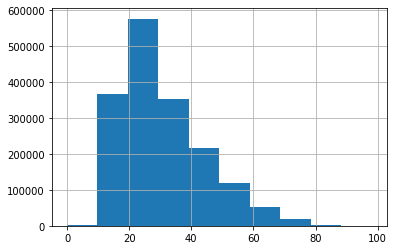

In [63]:
df['Age'].hist()

In [64]:
## categorizando o genero
samples['Sex'] = samples["Sex"].astype('category')
samples['Equipment'] = samples["Equipment"].astype('category')
samples['Sex'] = samples['Sex'].cat.codes

In [12]:
samples.head()

,Name,Sex,Event,Equipment,Age,AgeClass,BirthYearClass,Division,BodyweightKg,WeightClassKg,...,Tested,Country,State,Federation,ParentFederation,Date,MeetCountry,MeetState,MeetTown,MeetName
1741586,Ekaterina Lebedeva,0,SBD,Raw,32.5,24-34,24-39,Open,47.00,47,...,Yes,NaN,NaN,FPR,IPF,2016-11-11,Russia,ME,Yoshkar-Ola,Mari El Classic Powerlifting Cup
803133,Hannah Kincannon,0,SBD,Single-ply,NaN,18-19,NaN,Girls,64.05,67.3,...,Yes,NaN,NaN,THSWPA,NaN,2019-01-31,USA,TX,Bridge City Middle School,Bridge City Invitational
1215122,Mike Sarver,1,SBD,Single-ply,NaN,NaN,NaN,Open,75.00,75,...,NaN,NaN,NaN,USPF,IPF,1983-10-29,USA,WV,Huntington,Mountaineer Open
1288103,Sean Kaneshiro,1,B,Single-ply,NaN,NaN,24-39,Open,75.00,75,...,Yes,NaN,NaN,AAU,NaN,1998-11-22,USA,CA,Moreno Valley,World Bench Press Championships
724250,Amber Gonzales,0,SBD,Single-ply,NaN,NaN,NaN,Girls,129.05,117.7+,...,Yes,NaN,NaN,THSWPA,NaN,2017-01-14,USA,TX,Palo Alto College,Brooks Academy Invitational


In [13]:
samples['Age'].describe()

count    170990.000000
mean         30.828110
std          13.182609
min           0.000000
25%          20.500000
50%          27.500000
75%          38.500000
max          95.500000
Name: Age, dtype: float64

In [14]:
samples['Division'].value_counts()

Open            76103
Boys            36709
Girls           15647
Juniors          9219
Amateur Open     6681
                ...  
M-M2B-MP-T          1
M_MEM_3_BPU         1
Open+Masters        1
F_MCR_2_IPO         1
M_MEM_5_IPO         1
Name: Division, Length: 2619, dtype: int64

In [15]:
samples['Sex'].value_counts()

1     207907
0      66337
Mx         1
Name: Sex, dtype: int64

### Hipótese 1

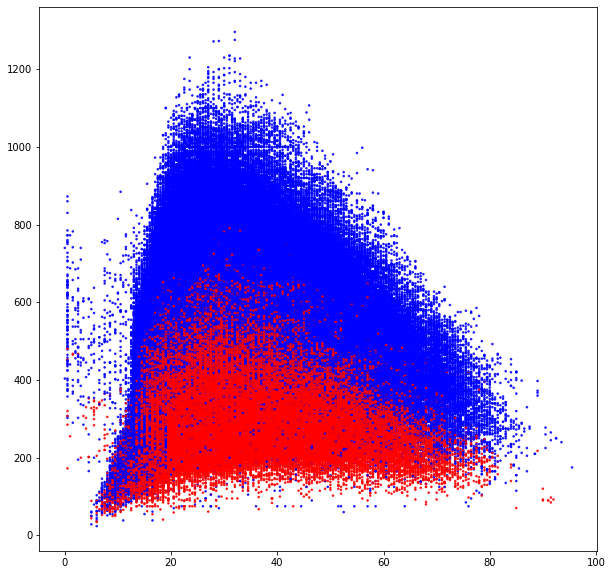

In [66]:
## peso total por idade, separado por genero
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(samples['Age'], samples['TotalKg'], alpha=0.8, s=2.5,
           c=['r' if x == 0 else 'b' for x in samples['Sex']])

### Hipótese2

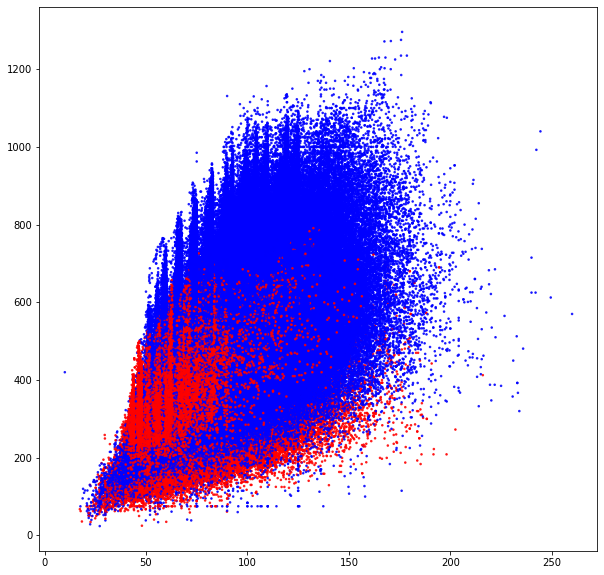

In [76]:
## peso total por peso corporal, separado por genero
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(samples['BodyweightKg'], samples['TotalKg'], alpha=0.8, s=2.5,
           c=['r' if x == 0 else 'b' for x in samples['Sex']])

In [17]:
samples['WeightClassKg'].value_counts()[0:10]

90      22206
75      20779
100     20387
82.5    19597
67.5    14612
110     14553
125     10432
93       9053
83       8807
60       8074
Name: WeightClassKg, dtype: int64

In [18]:
samples['BodyweightKg'].describe()

count    270617.00000
mean         84.00027
std          22.70205
min          10.00000
25%          67.04000
50%          81.90000
75%          98.80000
max         242.50000
Name: BodyweightKg, dtype: float64

In [67]:
samples['Name'].value_counts()

Jackie Blasbery       156
Jenny Hunter          151
Kevin Jane            139
Karel Ruso            136
Max Bristow           125
                     ... 
Simon Hogsten           1
Anatoliy Avramenko      1
Amrit-Sadhana Boyd      1
B. Trail                1
Janis Gilbreth          1
Name: Name, Length: 503975, dtype: int64

### Hipótese 3

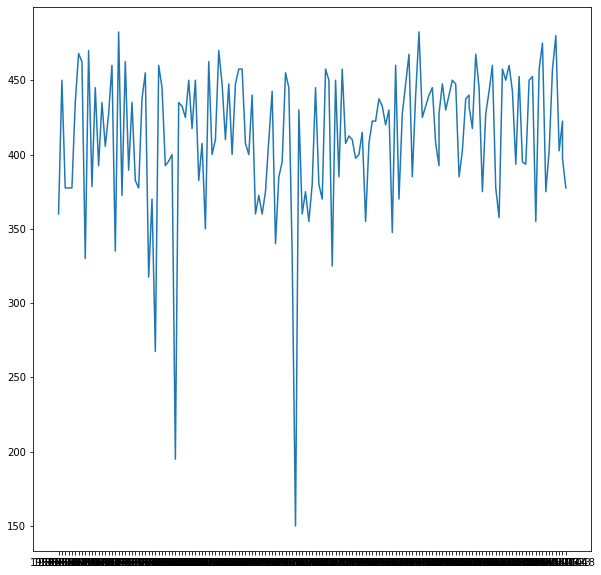

In [71]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.plot(samples[(samples["Name"] == 'Jackie Blasbery')]['Date'].sort_values(),samples[(samples["Name"] == 'Jackie Blasbery')]['TotalKg'])

In [21]:
samples['Equipment'].value_counts()

Single-ply    131119
Raw           112757
Wraps          17945
Multi-ply      11713
Unlimited        704
Straps             7
Name: Equipment, dtype: int64

<AxesSubplot:>

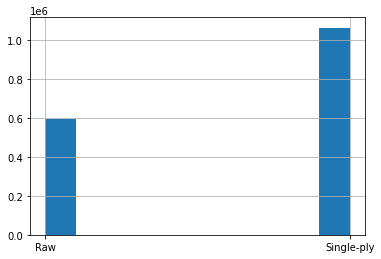

In [72]:
samples['Equipment'].hist()

### Hipótese 4

In [73]:
squat1 = samples[(samples['Equipment'] == 'Single-ply') & (samples['Squat1Kg'] >= 0)]['Squat1Kg']
squat2 = samples[(samples['Equipment'] == 'Single-ply') & (samples['Squat2Kg'] >= 0)]['Squat2Kg']
squat3 = samples[(samples['Equipment'] == 'Single-ply') & (samples['Squat3Kg'] >= 0)]['Squat3Kg']
squat4 = samples[(samples['Equipment'] == 'Single-ply') & (samples['Squat4Kg'] >= 0)]['Squat4Kg']

squat1_raw = samples[(samples['Equipment'] == 'Raw') & (samples['Squat1Kg'] >= 0)]['Squat1Kg']
squat2_raw = samples[(samples['Equipment'] == 'Raw') & (samples['Squat2Kg'] >= 0)]['Squat2Kg']
squat3_raw = samples[(samples['Equipment'] == 'Raw') & (samples['Squat3Kg'] >= 0)]['Squat3Kg']
squat4_raw = samples[(samples['Equipment'] == 'Raw') & (samples['Squat4Kg'] >= 0)]['Squat4Kg']

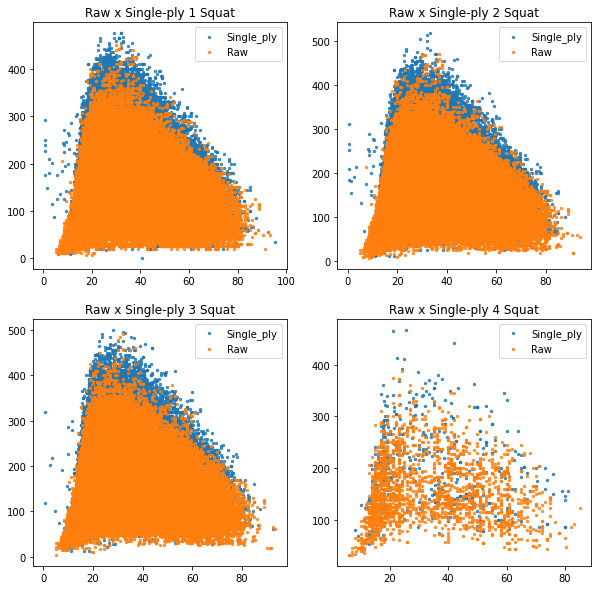

In [74]:
fig, axs = plt.subplots(2,2, figsize=(10, 10))
axs[0,0].scatter(samples[(samples['Equipment'] == 'Single-ply') & (samples['Squat1Kg'] >= 0)]['Age'], squat1, label = 'Single_ply', alpha=0.8, s=5.5)
axs[0,0].scatter(samples[(samples['Equipment'] == 'Raw') & (samples['Squat1Kg'] >= 0)]['Age'], squat1_raw, label = 'Raw', alpha=0.8, s=5.5)
axs[0,0].set_title('Raw x Single-ply 1 Squat')
axs[0,0].legend()

axs[0,1].scatter(samples[(samples['Equipment'] == 'Single-ply') & (samples['Squat2Kg'] >= 0)]['Age'], squat2, label = 'Single_ply', alpha=0.8, s=5.5)
axs[0,1].scatter(samples[(samples['Equipment'] == 'Raw') & (samples['Squat2Kg'] >= 0)]['Age'], squat2_raw, label = 'Raw', alpha=0.8, s=5.5)
axs[0,1].set_title('Raw x Single-ply 2 Squat')
axs[0,1].legend()

axs[1,0].scatter(samples[(samples['Equipment'] == 'Single-ply') & (samples['Squat3Kg'] >= 0)]['Age'], squat3, label = 'Single_ply', alpha=0.8, s=5.5)
axs[1,0].scatter(samples[(samples['Equipment'] == 'Raw') & (samples['Squat3Kg'] >= 0)]['Age'], squat3_raw, label = 'Raw', alpha=0.8, s=5.5)
axs[1,0].set_title('Raw x Single-ply 3 Squat')
axs[1,0].legend()

axs[1,1].scatter(samples[(samples['Equipment'] == 'Single-ply') & (samples['Squat4Kg'] >= 0)]['Age'], squat4, label = 'Single_ply', alpha=0.8, s=5.5)
axs[1,1].scatter(samples[(samples['Equipment'] == 'Raw') & (samples['Squat4Kg'] >= 0)]['Age'], squat4_raw, label = 'Raw', alpha=0.8, s=5.5)
axs[1,1].set_title('Raw x Single-ply 4 Squat')

axs[1,1].legend()
plt.show()